# 6.2. Environment setup and data

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
adata = sc.read_10x_mtx(
    path = "../../0_outs/sample-SRR15058452/filtered_feature_bc_matrix",
)
adata

AnnData object with n_obs × n_vars = 8852 × 32285
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 8852 × 32285
    var: 'gene_ids', 'feature_types'

# 6.3. Filtering low quality reads

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 8852 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

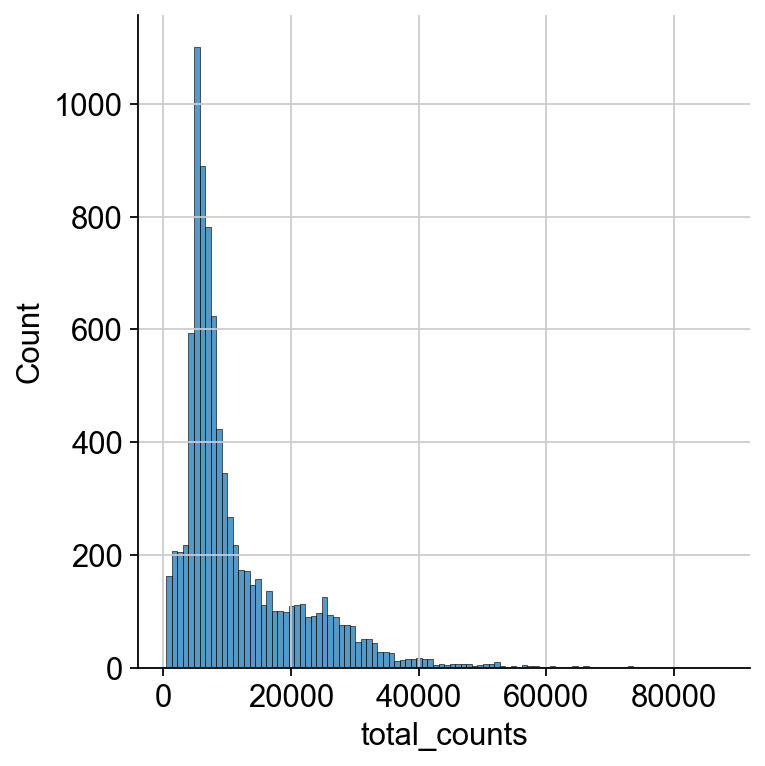

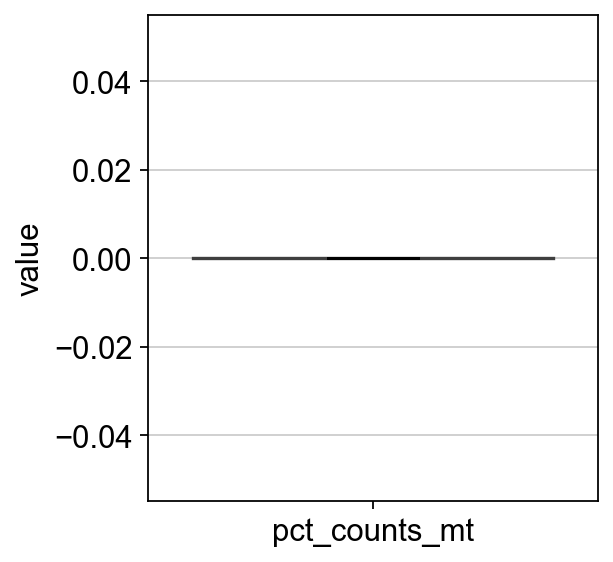

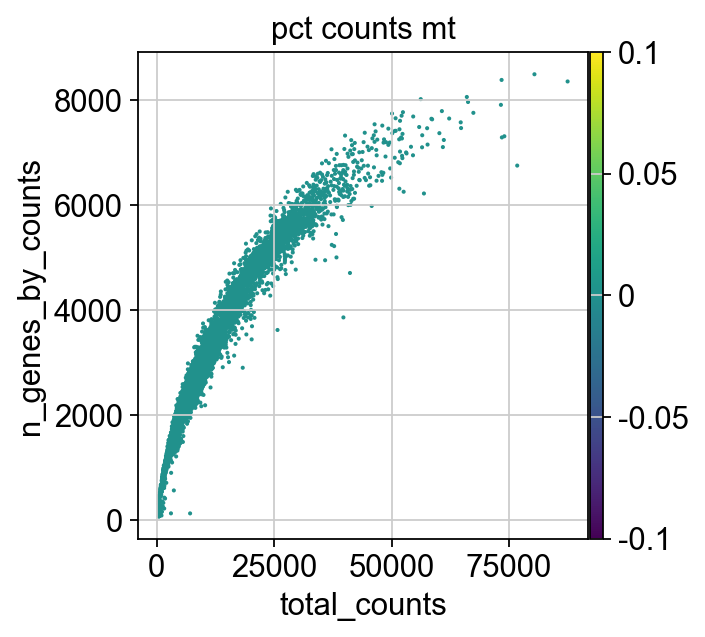

In [6]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    8509
True      343
Name: outlier, dtype: int64

In [9]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    8852
Name: mt_outlier, dtype: int64

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 8852
Number of cells after filtering of low quality cells: 8509


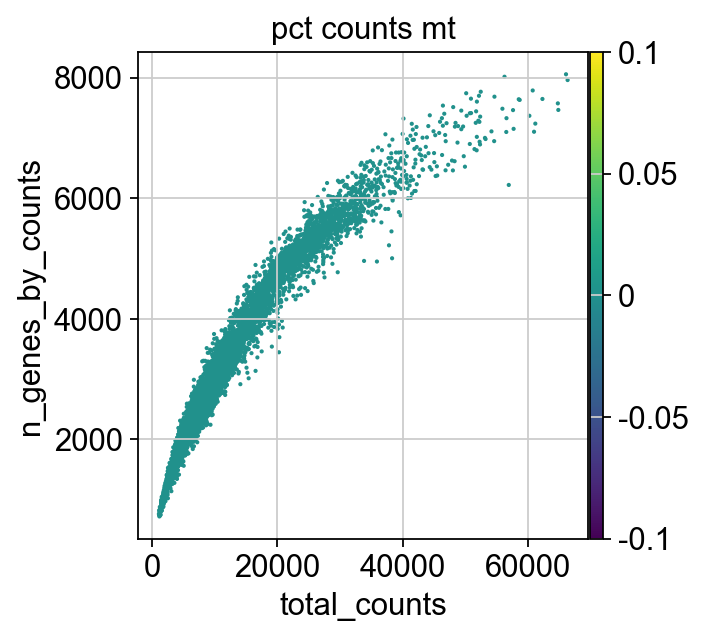

In [11]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# 6.4. Correction of ambient RNA

In [12]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [14]:
%%R
install.packages('SoupX')
library(SoupX)

--- Proszę wybrać serwer lustrzany CRAN do użycia w tej sesji ---


Fontconfig warning: ignoring UTF-8: not a valid region tag



Pobrane pakiety binarne są w
	/var/folders/x1/7112ysln0nl2vyr99j1nllf40000gp/T//RtmpGRh8NA/downloaded_packages

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [15]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [16]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

/Users/adrian/opt/anaconda3/envs/mamba/envs/simpleaf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
del adata_pp

In [18]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [19]:
adata_raw = sc.read_10x_mtx(
    path = "../../0_outs/sample-SRR15058452/raw_feature_bc_matrix",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

In [20]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

In [21]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [22]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 32285
Number of genes after cell filter: 15954


In [23]:
# 6.5. Doublet Detection

In [28]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [27]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("scater", update = FALSE)
BiocManager::install("scDblFinder", update = FALSE)


Pobrane pakiety binarne są w
	/var/folders/x1/7112ysln0nl2vyr99j1nllf40000gp/T//RtmpGRh8NA/downloaded_packages


In [29]:
data_mat = adata.X.T

In [30]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [31]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

1    7638
2     871
Name: scDblFinder_class, dtype: int64

In [32]:
adata.write("../../0_outs/sample-SRR15058452/SRR15058452_quality_control.h5ad")